# Install all necessary packages in colab

In [1]:
# Install necessary libraries if not already installed
!pip install geopy googlemaps pandas scikit-learn textblob wordcloud beautifulsoup4 nltk langid

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40715 sha256=1636470049f9f97ee02d72750ead83b688731df2828adede53de440952f6e8f1
  Stored in directory: /root/.cache/pip/wheels/f1/09/77/3cc2f5659cbc62341b30f806aca2b25e6a26c351daa5b1f49a
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=a11d94b86e07e96d11626c8b93a47daad4293c2e59715fe32a37069e93a0875f
  Stored in directory: /root/.cache/pip/wheels/32/6a/b6/b7eb43a6ad55b139c15c5daa29f3707659cfa6944d3c696f5b
Successfully built googlemaps langid


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# 1.Load files

In [1]:
import lzma
import json
import pandas as pd
from geopy.geocoders import GoogleV3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import isnull
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import langid
import nltk
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier

## 1.1 Load files from Google Drive

In [2]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/seek_data/job_event_join_df.csv' # Replace with the actual path to your file
try:
  job_event_join_df = pd.read_csv(file_path)
  print(job_event_join_df.head())
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except Exception as e:
  print(f"An error occurred: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Unnamed: 0  resume_id    job_id event_platform kind  \
0           0         56  38817504            WEB    V   
1           1         56  38817886            WEB    V   
2           2         56  38819020            WEB    V   
3           3         56  38830811            WEB    V   
4           4         56  38840675            WEB    V   

                                       cleaned_title  \
0  assistant restaurant manager growing sydney re...   
1                              supply demand planner   
2                                 research assistant   
3                                          caregiver   
4                                     sale executive   

                         classification                 sub_classification  \
0                 Hospitality & Tourism                         Management   
1  Manufacturing, Transport &

## 1.2 Load files from local files

In [4]:
# job_event_join_df = pd.read_csv('data/job_event_join_df.csv')

# 2.Preprocess the data

In [7]:
job_event_join_df = job_event_join_df[['resume_id', 'job_id', 'event_platform',
       'kind', 'cleaned_title', 'classification', 'sub_classification',
       'work_type', 'latitude', 'longitude','region_code', 'state', 'country',
       'abstract_content', 'salary_value','salary_unit']]

In [11]:
job_event_join_df["resume_id"] = job_event_join_df["resume_id"].astype('str')
job_event_join_df["job_id"] = job_event_join_df["job_id"].astype('str')

In [12]:
job_event_join_df['cleaned_title'].fillna('NA',inplace = True)
job_event_join_df['abstract_content'].fillna('NA',inplace = True)
job_event_join_df['salary_unit'].fillna('NA',inplace = True)
job_event_join_df['salary_value'].fillna(0,inplace = True)

<ipython-input-12-9e1b942bfda6>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  job_event_join_df['cleaned_title'].fillna('NA',inplace = True)
<ipython-input-12-9e1b942bfda6>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

## 2.1. Group records if same job was viewed and applied multiple times

In [10]:
job_event_join_df.columns

Index(['resume_id', 'job_id', 'event_platform', 'kind', 'cleaned_title',
       'classification', 'sub_classification', 'work_type', 'latitude',
       'longitude', 'region_code', 'state', 'country', 'abstract_content',
       'salary_value', 'salary_unit'],
      dtype='object')

In [11]:
view_apply_result = job_event_join_df.groupby(['resume_id','job_id'])['kind'].min().reset_index()
job_event_join_df = job_event_join_df.merge(view_apply_result, left_on=['resume_id','job_id'], right_on=['resume_id','job_id'], how='left')
job_event_join_df.columns = ['resume_id', 'job_id', 'event_platform', 'kind',
       'cleaned_title', 'classification', 'sub_classification',
       'work_type', 'latitude', 'longitude',
       'region_code', 'state', 'country', 'abstract_content', 'salary_value',
       'salary_unit', 'final_kind']

print(f'Before groupby:{len(job_event_join_df)}')
job_event_join_df = job_event_join_df.groupby(['resume_id', 'job_id']).last().reset_index()
print(f'Before groupby:{len(job_event_join_df)}')

Before groupby:1423733
Before groupby:1095803


In [12]:
job_event_join_df = job_event_join_df[['resume_id', 'job_id', 'event_platform',
       'cleaned_title', 'classification', 'sub_classification',
       'work_type', 'latitude', 'longitude',
       'region_code', 'state', 'country', 'abstract_content', 'salary_value',
       'salary_unit', 'final_kind']]
job_event_join_df.columns = ['resume_id', 'job_id', 'event_platform',
       'cleaned_title', 'classification', 'sub_classification',
       'work_type', 'latitude', 'longitude',
       'region_code', 'state', 'country', 'abstract_content', 'salary_value',
       'salary_unit', 'kind']

In [13]:
job_event_join_df_grouped = job_event_join_df.groupby('resume_id').agg({'job_id': lambda x: len(set(x))}).reset_index()
# filter for records less than 100
selected_resume_id = job_event_join_df_grouped[job_event_join_df_grouped['job_id']>100]['resume_id'].unique()
# selected_resume_id = ['245','879','3488','92','15','6','1000','10142']

In [14]:
# Initialize empty dataframes for train and validation
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Split interactions for each resume_id
for resume_id, group in job_event_join_df[job_event_join_df["resume_id"].isin(selected_resume_id)].groupby('resume_id'):
    train_group, val_group = train_test_split(group, test_size=0.2, random_state=42)
    train_data = pd.concat([train_data, train_group])
    val_data = pd.concat([val_data, val_group])



## 2.2. Convert coordinates to distance

Assuming the centroid of all job applied/viewed is the location of each applicant, by getting the centroid coordinates from training data, distance can be calculated for all data, including validation data

In [3]:
# Haversine formula to calculate distance between two points on Earth
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    :param lat1, lon1: latitude and longitude of point 1 (in degrees).
    :param lat2, lon2: latitude and longitude of point 2 (in degrees).
    :return: Distance in kilometers.
    """
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

train_data_per_resume_job = train_data.groupby(['resume_id','job_id'])[["latitude", "longitude"]].first().reset_index()
centroids = train_data_per_resume_job.groupby("resume_id")[["latitude", "longitude"]].mean().reset_index()
centroids.columns = ["resume_id", "center_latitude", "center_longitude"]
train_data_per_resume_job = train_data_per_resume_job.merge(centroids, on="resume_id")
# Calculate distance to the center for each location
train_data_per_resume_job["distance_to_center"] = train_data_per_resume_job.apply(
    lambda row: haversine(row["latitude"], row["longitude"], row["center_latitude"], row["center_longitude"]),
    axis=1
)
# Find the farthest distance for each candidate
job_range_distances = train_data_per_resume_job.groupby("resume_id")["distance_to_center"].agg(['max', 'min', 'mean']).reset_index()
job_range_distances.columns = ["resume_id", "farthest_distance_to_center_km","shortest_distance_to_center_km","average_distance_to_center_km"]


train_data = train_data.merge(job_range_distances, on="resume_id")
train_data = train_data.merge(centroids, on="resume_id")
train_data["distance"] = train_data.apply(lambda row: haversine(row["latitude"], row["longitude"], row["center_latitude"], row["center_longitude"]),
    axis=1)

val_data = val_data.merge(job_range_distances, on="resume_id")
val_data = val_data.merge(centroids, on="resume_id")
val_data["distance"] = val_data.apply(lambda row: haversine(row["latitude"], row["longitude"], row["center_latitude"], row["center_longitude"]),
    axis=1)

NameError: name 'train_data' is not defined

## 2.3. Get keywords from title and abstrate_content

The TfidfVectorizer is used per classification to get the most relevant keywords for each classification

In [16]:
custom_stop_words = ["please","letter","within","at","of","looking","their","they","about","are","if","have","is","us","on","our","this","to","be","for","in","with","i","you","we","a","and","the","will", "join", "work", "opportunity", "new", "role", "based","company","currently","duty","candidate","applicant","end","position","skills","ability",'application','applications',"apply","click","responsibility","responsibilities"]

### 2.3.1 Keywords fro abstract_content

In [17]:
def extract_keywords(tfidf_matrix, feature_names, doc_idx, top_n=5):
    tfidf_scores = zip(feature_names, tfidf_matrix[doc_idx].toarray()[0])
    sorted_keywords = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    return [word for word, score in sorted_keywords[:top_n]]

tfidf_abstract_content_list = {}
# add keywords for all jobs
# Keyword Extraction by Classification
for classification, group in train_data.groupby('classification'):
    print(classification)
    tfidf = TfidfVectorizer(max_features=100, stop_words='english',ngram_range=(2, 3))
    tfidf.set_params(stop_words=list(tfidf.get_stop_words()) + custom_stop_words)
    tfidf_matrix = tfidf.fit_transform(group['abstract_content'])
    tfidf_abstract_content_list[classification]={}
    tfidf_abstract_content_list[classification]["tfidf"] = tfidf
    tfidf_abstract_content_list[classification]["tfidf_matrix"] = tfidf_matrix
    feature_names = tfidf.get_feature_names_out()
    # Extract keywords for the filtered rows
    keywords_list = [extract_keywords(tfidf_matrix, tfidf.get_feature_names_out(), i, top_n=5) for i in range(len(group))]
    # Assign the keywords to the 'keywords' column for the filtered rows
    train_data.loc[train_data['classification'] == classification,'abstract_content_keywords'] = [', '.join(keywords) for keywords in keywords_list]
    # print(f"\nTop keywords for {classification}: {feature_names}")

Accounting
Administration & Office Support
Advertising, Arts & Media
Banking & Financial Services
CEO & General Management
Call Centre & Customer Service
Community Services & Development
Construction
Consulting & Strategy
Design & Architecture
Education & Training
Engineering
Farming, Animals & Conservation
Government & Defence
Healthcare & Medical
Hospitality & Tourism
Human Resources & Recruitment
Information & Communication Technology
Insurance & Superannuation
Legal
Manufacturing, Transport & Logistics
Marketing & Communications
Mining, Resources & Energy
Real Estate & Property
Retail & Consumer Products
Sales
Science & Technology
Self Employment
Sport & Recreation
Trades & Services


In [18]:
for classification, group in val_data.groupby('classification'):
    tfidf = tfidf_abstract_content_list[classification]["tfidf"]
    tfidf_matrix = tfidf.transform(group['abstract_content'])
    feature_names = tfidf.get_feature_names_out()
    # Extract keywords for the filtered rows
    keywords_list = [extract_keywords(tfidf_matrix, tfidf.get_feature_names_out(), i, top_n=5) for i in range(len(group))]
    # Assign the keywords to the 'keywords' column for the filtered rows
    val_data.loc[val_data['classification'] == classification,'abstract_content_keywords'] = [', '.join(keywords) for keywords in keywords_list]

### 2.3.2 Keywords for title

In [19]:
tfidf_title_list = {}
# add keywords for all jobs
# Keyword Extraction by Classification
for classification, group in train_data.groupby('classification'):
    print(classification)
    tfidf = TfidfVectorizer(max_features=100, stop_words='english',ngram_range=(2, 3))
    tfidf.set_params(stop_words=list(tfidf.get_stop_words()) + custom_stop_words)
    tfidf_matrix = tfidf.fit_transform(group['cleaned_title'])
    tfidf_title_list[classification]={}
    tfidf_title_list[classification]["tfidf"] = tfidf
    tfidf_title_list[classification]["tfidf_matrix"] = tfidf_matrix
    feature_names = tfidf.get_feature_names_out()
    # Extract keywords for the filtered rows
    keywords_list = [extract_keywords(tfidf_matrix, tfidf.get_feature_names_out(), i, top_n=5) for i in range(len(group))]
    # Assign the keywords to the 'keywords' column for the filtered rows
    train_data.loc[train_data['classification'] == classification,'title_keywords'] = [', '.join(keywords) for keywords in keywords_list]
    # print(f"\nTop keywords for {classification}: {feature_names}")

Accounting
Administration & Office Support
Advertising, Arts & Media
Banking & Financial Services
CEO & General Management
Call Centre & Customer Service
Community Services & Development
Construction
Consulting & Strategy
Design & Architecture
Education & Training
Engineering
Farming, Animals & Conservation
Government & Defence
Healthcare & Medical
Hospitality & Tourism
Human Resources & Recruitment
Information & Communication Technology
Insurance & Superannuation
Legal
Manufacturing, Transport & Logistics
Marketing & Communications
Mining, Resources & Energy
Real Estate & Property
Retail & Consumer Products
Sales
Science & Technology
Self Employment
Sport & Recreation
Trades & Services


In [20]:
for classification, group in val_data.groupby('classification'):
    tfidf = tfidf_title_list[classification]["tfidf"]
    tfidf_matrix = tfidf.transform(group['cleaned_title'])
    feature_names = tfidf.get_feature_names_out()
    # Extract keywords for the filtered rows
    keywords_list = [extract_keywords(tfidf_matrix, tfidf.get_feature_names_out(), i, top_n=5) for i in
                     range(len(group))]
    # Assign the keywords to the 'keywords' column for the filtered rows
    val_data.loc[val_data['classification'] == classification, 'title_keywords'] = [', '.join(keywords) for
                                                                                                 keywords in
                                                                                                 keywords_list]

In [21]:
# Assuming 'train_data' and 'val_data' are your DataFrames
train_data_path = '/content/drive/MyDrive/seek_data/train_data.csv'
val_data_path = '/content/drive/MyDrive/seek_data/val_data.csv'
try:
  train_data.to_csv(train_data_path, index=False)  # Set index=False to avoid saving row indices
  print(f"Training data saved to {train_data_path}")

  val_data.to_csv(val_data_path, index=False)
  print(f"Validation data saved to {val_data_path}")

except Exception as e:
  print(f"An error occurred while saving the data: {e}")


Training data saved to /content/drive/MyDrive/seek_data/train_data.csv
Validation data saved to /content/drive/MyDrive/seek_data/val_data.csv


In [4]:
# Read from train_data and val_data to skip preprocessing
file_path = '/content/drive/MyDrive/seek_data/train_data.csv'
try:
  train_data = pd.read_csv(file_path)
  # print(train_data.head())
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except Exception as e:
  print(f"An error occurred: {e}")

file_path = '/content/drive/MyDrive/seek_data/val_data.csv'
try:
  val_data = pd.read_csv(file_path)
  # print(val_data.head())
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except Exception as e:
  print(f"An error occurred: {e}")

In [9]:
train_data["job_id"] = train_data["job_id"].astype(str)
train_data["resume_id"] = train_data["resume_id"].astype(str)
val_data["job_id"] = val_data["job_id"].astype(str)
val_data["resume_id"] = val_data["resume_id"].astype(str)
val_data['cleaned_title'].fillna('NA',inplace = True)
val_data['abstract_content'].fillna('NA',inplace = True)
val_data['salary_unit'].fillna('NA',inplace = True)
val_data['salary_value'].fillna(0,inplace = True)
train_data['cleaned_title'].fillna('NA',inplace = True)
train_data['abstract_content'].fillna('NA',inplace = True)
train_data['salary_unit'].fillna('NA',inplace = True)
train_data['salary_value'].fillna(0,inplace = True)

<ipython-input-9-af69c9e6c169>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  val_data['cleaned_title'].fillna('NA',inplace = True)
<ipython-input-9-af69c9e6c169>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

# 3.AI Solution

## 3.1. Step 1: Predict if one applicant will view a job

### 3.1.1 Prepare training and validation data
Since we dont have non-view or non-apply data, generate non-view data based on applicant data and jobs that viewed/applied by other applicants

In [6]:
len(train_data['resume_id'].unique())

2338

In [41]:
# because of the huge data volume and limited computing resource, randomly select some resume_id for analysis
# selected_resume_id_trial1 = ['245','879','3488','92','15','6','1000','10142', '1001', '100178', '10018', '100184', '10023', '100284',
#        '100310', '100317', '10037', '100388', '1004', '10040', '100452',
#        '1005', '100528', '10057', '100833', '100848', '1009']
selected_resume_id_trial1 = train_data['resume_id'].unique()[0:500]
train_data_selected = train_data[train_data['resume_id'].isin(selected_resume_id_trial1)]
val_data_selected = val_data[val_data['resume_id'].isin(selected_resume_id_trial1)]

# train_data_selected = train_data
# val_data_selected = val_data
# Get all unique jobs
all_jobs = train_data_selected['job_id'].unique()

# Initialize lists to store features and labels
X_train_views = []  # Features (user-job pairs)
y_train_views = []  # Labels (1 = viewed, 0 = not viewed)

# Iterate over each user
for user_id in train_data_selected['resume_id'].unique():
    user_data = train_data_selected[train_data_selected['resume_id']==user_id][['center_latitude', 'center_longitude','event_platform','farthest_distance_to_center_km', 'shortest_distance_to_center_km',
       'average_distance_to_center_km']].iloc[0]
    # Get jobs the user viewed
    viewed_jobs = train_data_selected[(train_data_selected['resume_id'] == user_id) & ((train_data_selected['kind'] == 'V') | (train_data['kind'] == 'A'))]['job_id'].unique().tolist()
    # Get jobs the user did not view (negative samples)
    non_viewed_jobs = list(set(all_jobs) - set(viewed_jobs))
    size_negative = min(len(viewed_jobs),len(non_viewed_jobs))
    negative_samples = np.random.choice(non_viewed_jobs, size=size_negative, replace=False)
    # Add positive samples (viewed jobs)
    for job_id in viewed_jobs:
        X_train_views.append((user_id, job_id, user_data[0], user_data[1], user_data[2], user_data[3], user_data[4], user_data[5])) # Features: user-job pair
        y_train_views.append(1)  # Label: viewed

    # Add negative samples (non-viewed jobs)
    for job_id in negative_samples:
        X_train_views.append((user_id, job_id, user_data[0], user_data[1], user_data[2], user_data[3], user_data[4], user_data[5]))
        y_train_views.append(0)  # Label: not viewed

# Convert to numpy arrays
X_train_views = np.array(X_train_views)
y_train_views = np.array(y_train_views)


<ipython-input-41-f539f6686ca1>:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  viewed_jobs = train_data_selected[(train_data_selected['resume_id'] == user_id) & ((train_data_selected['kind'] == 'V') | (train_data['kind'] == 'A'))]['job_id'].unique().tolist()
<ipython-input-41-f539f6686ca1>:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_train_views.append((user_id, job_id, user_data[0], user_data[1], user_data[2], user_data[3], user_data[4], user_data[5])) # Features: user-job pair
<ipython-input-41-f539f6686ca1>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_train_views.ap

In [42]:
# Get all unique jobs
all_jobs = val_data_selected['job_id'].unique()

# Initialize lists to store features and labels
X_val_views = []  # Features (user-job pairs)
y_val_views = []  # Labels (1 = viewed, 0 = not viewed)

# Iterate over each user
for user_id in val_data_selected['resume_id'].unique():
    # Get jobs the user viewed
    user_data = val_data_selected[val_data_selected['resume_id']==user_id][['center_latitude', 'center_longitude','event_platform','farthest_distance_to_center_km', 'shortest_distance_to_center_km',
       'average_distance_to_center_km']].iloc[0]
    viewed_jobs = val_data_selected[(val_data_selected['resume_id'] == user_id) & ((val_data_selected['kind'] == 'V') | (val_data['kind'] == 'A'))]['job_id'].unique().tolist()
    # Get jobs the user did not view (negative samples)
    non_viewed_jobs = [item for item in all_jobs if item not in viewed_jobs]

    # Randomly sample negative samples (e.g., same number as viewed jobs)
    # negative_samples = np.random.choice(non_viewed_jobs, size=len(viewed_jobs), replace=False)
    size_negative = min(len(viewed_jobs),len(non_viewed_jobs))
    negative_samples = np.random.choice(non_viewed_jobs, size=size_negative, replace=False)

    # Add positive samples (viewed jobs)
    for job_id in viewed_jobs:
        X_val_views.append((user_id, job_id, user_data[0], user_data[1], user_data[2], user_data[3], user_data[4], user_data[5]))  # Features: user-job pair
        y_val_views.append(1)  # Label: viewed

    # Add negative samples (non-viewed jobs)
    for job_id in negative_samples:
        X_val_views.append((user_id, job_id, user_data[0], user_data[1], user_data[2], user_data[3], user_data[4], user_data[5]))  # Features: user-job pair
        y_val_views.append(0)  # Label: not viewed

# Convert to numpy arrays
X_val_views = np.array(X_val_views)
y_val_views = np.array(y_val_views)


<ipython-input-42-0fef65260299>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  viewed_jobs = val_data_selected[(val_data_selected['resume_id'] == user_id) & ((val_data_selected['kind'] == 'V') | (val_data['kind'] == 'A'))]['job_id'].unique().tolist()
<ipython-input-42-0fef65260299>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_val_views.append((user_id, job_id, user_data[0], user_data[1], user_data[2], user_data[3], user_data[4], user_data[5]))  # Features: user-job pair
<ipython-input-42-0fef65260299>:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_val_views.append((user_

In [43]:
index_val_df = pd.DataFrame(X_val_views,columns=['resume_id','job_id','center_latitude', 'center_longitude','event_platform','farthest_distance_to_center_km', 'shortest_distance_to_center_km',
       'average_distance_to_center_km'])
index_val_df["label"] = y_val_views
index_train_df = pd.DataFrame(X_train_views,columns=['resume_id','job_id','center_latitude', 'center_longitude','event_platform','farthest_distance_to_center_km', 'shortest_distance_to_center_km',
       'average_distance_to_center_km'])
index_train_df["label"] = y_train_views

In [44]:
# merge job data to index_train_df
index_train_df = index_train_df.merge(train_data_selected[['job_id','latitude','longitude', 'classification', 'sub_classification', 'work_type',
        'region_code', 'country', 'salary_value', 'salary_unit', 'abstract_content_keywords', 'title_keywords']],left_on=["job_id"],right_on=["job_id"],how="left")
index_val_df = index_val_df.merge(val_data_selected[['job_id', 'latitude','longitude','classification', 'sub_classification', 'work_type',
        'region_code', 'country', 'salary_value', 'salary_unit', 'abstract_content_keywords', 'title_keywords']],left_on=["job_id"],right_on=["job_id"],how="left")

In [45]:
index_train_df = index_train_df[["label","resume_id",'job_id','center_latitude', 'center_longitude','event_platform','farthest_distance_to_center_km', 'shortest_distance_to_center_km',
       'average_distance_to_center_km','latitude','longitude','job_id', 'classification', 'sub_classification', 'work_type',
        'region_code', 'country', 'salary_value', 'salary_unit', 'abstract_content_keywords', 'title_keywords']]
index_val_df = index_val_df[["label","resume_id",'job_id','center_latitude', 'center_longitude','event_platform','farthest_distance_to_center_km', 'shortest_distance_to_center_km',
       'average_distance_to_center_km','latitude','longitude','job_id', 'classification', 'sub_classification', 'work_type',
        'region_code', 'country', 'salary_value', 'salary_unit', 'abstract_content_keywords', 'title_keywords']]

In [46]:
index_train_df["center_latitude"] = index_train_df["center_latitude"].astype(float)
index_train_df["center_longitude"] = index_train_df["center_longitude"].astype(float)
index_val_df["center_latitude"] = index_val_df["center_latitude"].astype(float)
index_val_df["center_longitude"] = index_val_df["center_longitude"].astype(float)

In [47]:
# Calculate distance between jobs and applicants
index_train_df["distance"] = index_train_df.apply(lambda row: haversine(row["latitude"], row["longitude"], row["center_latitude"], row["center_longitude"]),
    axis=1)
index_val_df["distance"] = index_val_df.apply(lambda row: haversine(row["latitude"], row["longitude"], row["center_latitude"], row["center_longitude"]),
    axis=1)

In [48]:
classification_cat = job_event_join_df["classification"].unique()
subclassification_cat = job_event_join_df["sub_classification"].unique()
resume_id_cat = job_event_join_df["resume_id"].unique()
event_platform_cat = job_event_join_df["event_platform"].unique()
salary_unit_cat = job_event_join_df["salary_unit"].unique()
region_code_cat = job_event_join_df["region_code"].unique()
work_type_cat = job_event_join_df["work_type"].unique()
preprocessor = ColumnTransformer(
    transformers=[
        ('Scaler', StandardScaler(), ['distance','farthest_distance_to_center_km','shortest_distance_to_center_km','average_distance_to_center_km','salary_value',]),
        ('onehot', OneHotEncoder(categories = [event_platform_cat,work_type_cat,region_code_cat,salary_unit_cat]), ['event_platform', 'work_type', 'region_code', 'salary_unit']),
        ('ordinal', OrdinalEncoder(categories=[classification_cat ,subclassification_cat, resume_id_cat]), ["classification" ,"sub_classification",'resume_id']),
        ('TfidfVectorizer', TfidfVectorizer(max_features=200,ngram_range=(2, 3)), "title_keywords"),
        ('TfidfVectorizer2', TfidfVectorizer(max_features=400,ngram_range=(2, 3)), "abstract_content_keywords")
    ])
preprocessor_pure = ColumnTransformer(
    transformers=[
        ('Scaler', StandardScaler(), ['distance','farthest_distance_to_center_km','shortest_distance_to_center_km','average_distance_to_center_km','salary_value',]),
        ('onehot', OneHotEncoder(categories = [event_platform_cat,work_type_cat,region_code_cat,salary_unit_cat]), ['event_platform', 'work_type', 'region_code', 'salary_unit']),
        ('ordinal', OrdinalEncoder(categories=[classification_cat ,subclassification_cat, resume_id_cat]), ["classification" ,"sub_classification",'resume_id'])
    ])
X_train_transformed_view = preprocessor.fit_transform(index_train_df)
X_val_transformed_view = preprocessor.fit_transform(index_val_df)

In [49]:
y_train_views = index_train_df["label"].values
y_val_views = index_val_df["label"].values

In [50]:
def threshold_check(threshold,array):
    return [1 if x[1] >= threshold else 0 for x in array]

def print_performance_metrics(prediction,label):
    accuracy = accuracy_score(label, prediction)
    precision = precision_score(label, prediction)
    recall = recall_score(label, prediction)
    f1 = f1_score(label, prediction)
    print(f"accuracy_score: {accuracy_score(label, prediction)}")
    print(f"precision_score: {precision_score(label, prediction)}")
    print(f"recall_score: {recall_score(label, prediction)}")
    print(f"f1_score: {f1_score(label, prediction)}")
    return accuracy,precision,recall,f1

In [51]:
def plot_roc_curve(y_prob,true_y, pos = 0):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob[:,pos])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(f'roc_auc_score: {roc_auc_score(true_y, y_prob[:,pos])}')
    return roc_auc_score(true_y, y_prob[:,pos])

### 3.1.2 Proposed Models

In [52]:
pca = PCA(n_components=80)  # Reduce to 15 components
X_train_view_pca = pca.fit_transform(X_train_transformed_view)
X_val_view_pca = pca.transform(X_val_transformed_view)

In [159]:
X_train_transformed_view.shape

(1210261, 623)

#### 3.1.2.1 Random Forest

In [143]:
rf_view_model = RandomForestClassifier()
history_view_rf = rf_view_model.fit(X_train_view_pca, y_train_views)

roc_auc_score: 0.45817131519787124


np.float64(0.45817131519787124)

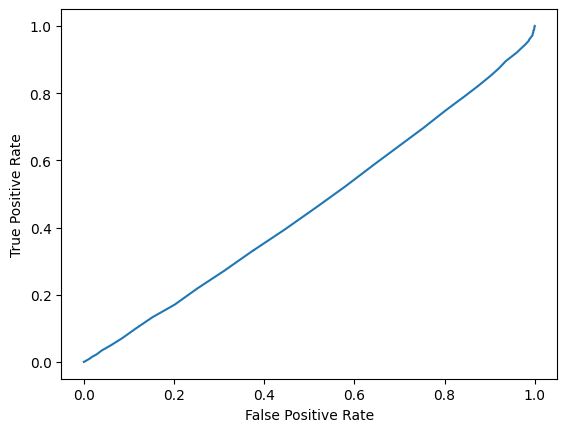

In [146]:
prediction_prob_view_rf = rf_view_model.predict_proba(X_val_view_pca)
plot_roc_curve(prediction_prob_view_rf,y_val_views)

In [177]:
prediction_view_rf = threshold_check(0.45,prediction_prob_view_rf)
accuracy,precision,recall,f1 = print_performance_metrics(prediction_view_rf,y_val_views)

accuracy_score: 0.5929221347331584
precision_score: 0.6873707777193262
recall_score: 0.7281622602384655
f1_score: 0.707178773938162


In [155]:
store_model(rf_view_model,'/content/drive/MyDrive/seek_data/model/rf_view_model_500.joblib')

In [131]:
prediction_view_rf = threshold_check(0.4685,prediction_prob_view_rf)
accuracy,precision,recall,f1 = print_performance_metrics(prediction_view_rf,y_val_views)

accuracy_score: 0.5537531196006911
precision_score: 0.5744380369542191
recall_score: 0.8253297260737233
f1_score: 0.6773992089376171


roc_auc_score: 0.45460830136603714


np.float64(0.45460830136603714)

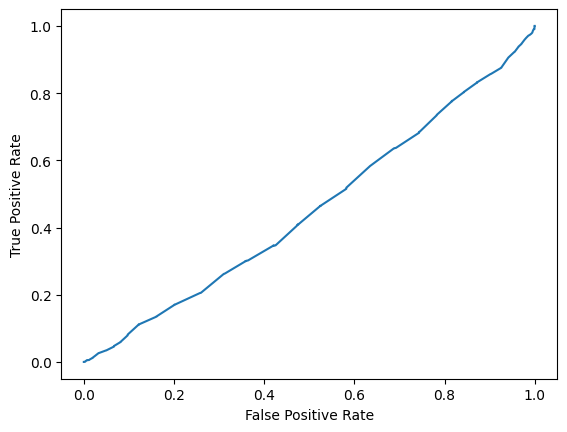

In [49]:
prediction_prob_view_rf = rf_view_model.predict_proba(X_val_view_pca)
plot_roc_curve(prediction_prob_view_rf,y_val_views)

In [104]:
prediction_view_rf = threshold_check(0.4,prediction_prob_view_rf)
accuracy,precision,recall,f1 = print_performance_metrics(prediction_view_rf,y_val_views)

accuracy_score: 0.650173064820642
precision_score: 0.6767166309778729
recall_score: 0.9215396578538103
f1_score: 0.7803769857601449


roc_auc_score: 0.4622710881475944


np.float64(0.4622710881475944)

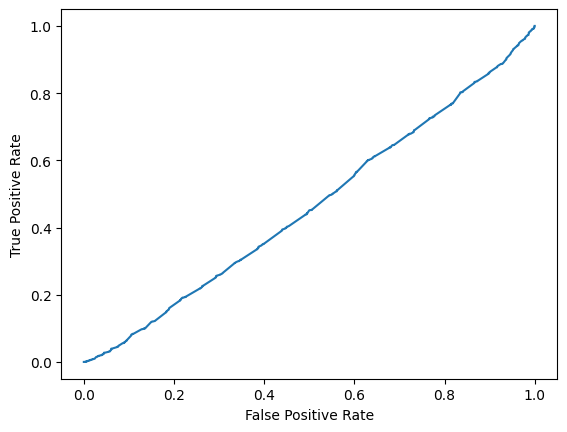

In [42]:
prediction_prob_view_rf = rf_view_model.predict_proba(X_val_view_pca)
plot_roc_curve(prediction_prob_view_rf,y_val_views)

In [173]:
prediction_view_rf = threshold_check(0.462,prediction_prob_view_rf)
accuracy,precision,recall,f1 = print_performance_metrics(prediction_view_rf,y_val_views)

accuracy_score: 0.5544794400699913
precision_score: 0.6941784218238872
recall_score: 0.6078019699326076
f1_score: 0.6481249870438575


roc_auc_score: 0.47902336168512394


0.47902336168512394

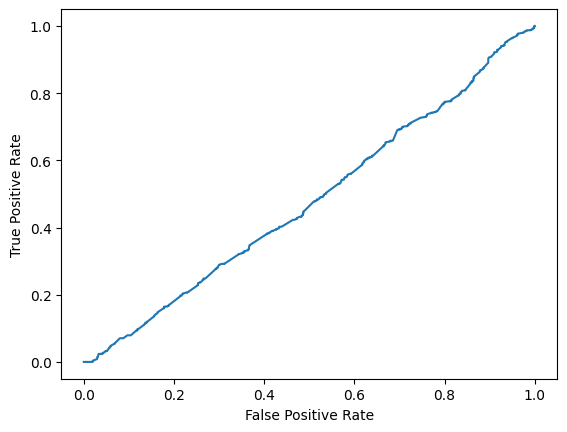

In [61]:
prediction_prob_view_rf = rf_view_model.predict_proba(X_val_view_pca)
plot_roc_curve(prediction_prob_view_rf,y_val_views)

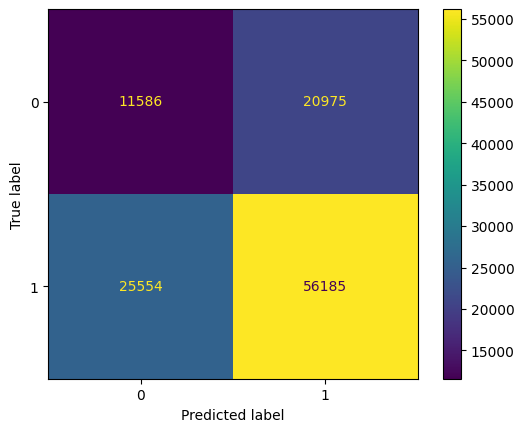

In [175]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions( y_val_views,prediction_view_rf)

In [62]:
prediction_view_rf = threshold_check(0.479,prediction_prob_view_rf)
accuracy,precision,recall,f1 = print_performance_metrics(prediction_view_rf,y_val_views)

accuracy_score: 0.5169029443838604
precision_score: 0.5168855534709194
recall_score: 0.5976138828633406
f1_score: 0.5543259557344065


#### 3.1.2.2 Neural Network

In [53]:
# Define the model
nn_view_model = Sequential([
    Dense(128, activation='relu', input_shape=(pd.DataFrame(X_train_view_pca).shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
nn_view_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','precision','recall','f1_score'])

# Train the model
history_view_nn = nn_view_model.fit(pd.DataFrame(X_train_view_pca), pd.DataFrame(y_train_views), epochs=10, batch_size=64, validation_data=(pd.DataFrame(X_val_view_pca), pd.DataFrame(y_val_views)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
18931/18931 ━━━━━━━━━━━━━━━━━━━━ 113s 6ms/step - accuracy: 0.7211 - f1_score: 0.8662 - loss: 7.8530 - precision: 0.7789 - recall: 0.8962 - val_accuracy: 0.6733 - val_f1_score: 0.8047 - val_loss: 0.6638 - val_precision: 0.6733 - val_recall: 1.0000
Epoch 2/10
18931/18931 ━━━━━━━━━━━━━━━━━━━━ 75s 4ms/step - accuracy: 0.7788 - f1_score: 0.8757 - loss: 0.5289 - precision: 0.7789 - recall: 0.9998 - val_accuracy: 0.6733 - val_f1_score: 0.8047 - val_loss: 0.6624 - val_precision: 0.6733 - val_recall: 1.0000
Epoch 3/10
18931/18931 ━━━━━━━━━━━━━━━━━━━━ 100s 5ms/step - accuracy: 0.7788 - f1_score: 0.8756 - loss: 0.5288 - precision: 0.7788 - recall: 1.0000 - val_accuracy: 0.6733 - val_f1_score: 0.8047 - val_loss: 0.6627 - val_precision: 0.6733 - val_recall: 1.0000
Epoch 4/10
18931/18931 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - accuracy: 0.7789 - f1_score: 0.8757 - loss: 0.5290 - precision: 0.7790 - recall: 1.0000 - val_accuracy: 0.6733 - val_f1_score: 0.8047 - val_loss: 0.6599 - val_precision

3582/3582 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
roc_auc_score: 0.5003937819177688


np.float64(0.5003937819177688)

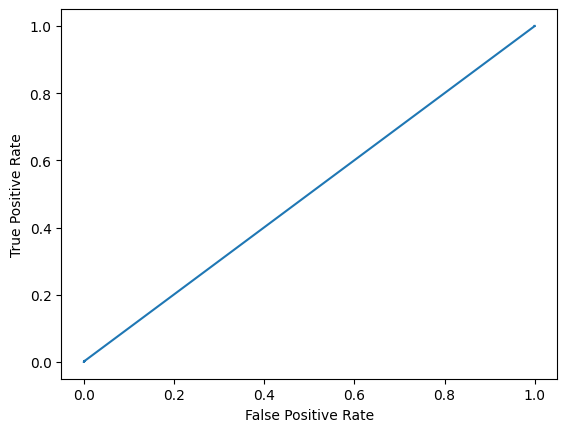

In [56]:
prediction_prob_view_nn = nn_view_model.predict(X_val_view_pca)
plot_roc_curve(prediction_prob_view_nn,y_val_views)

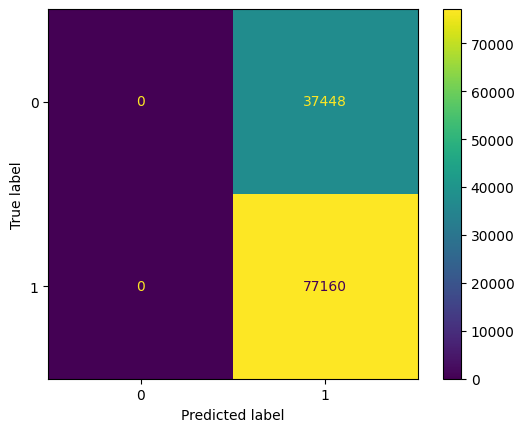

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions( y_val_views,prediction_view_nn)

In [57]:
prediction_view_nn = tf.cast(prediction_prob_view_nn >= 0.5, tf.int32)
accuracy,precision,recall,f1 = print_performance_metrics(prediction_view_nn,y_val_views)

accuracy_score: 0.6732514309646797
precision_score: 0.6732514309646797
recall_score: 1.0
f1_score: 0.8047223728672146


## 3.2. Step 2: Predict if one applicant will apply for a job

### 3.2.1 Prepare training and validation data

In [13]:
classification_cat = job_event_join_df["classification"].unique()
subclassification_cat = job_event_join_df["sub_classification"].unique()
resume_id_cat = job_event_join_df["resume_id"].unique()
event_platform_cat = job_event_join_df["event_platform"].unique()
salary_unit_cat = job_event_join_df["salary_unit"].unique()
region_code_cat = job_event_join_df["region_code"].unique()
work_type_cat = job_event_join_df["work_type"].unique()
preprocessor_apply = ColumnTransformer(
    transformers=[
        ('Scaler', StandardScaler(), ['distance','farthest_distance_to_center_km','shortest_distance_to_center_km','average_distance_to_center_km','salary_value',]),
        ('onehot', OneHotEncoder(categories = [event_platform_cat,work_type_cat,region_code_cat,salary_unit_cat]), ['event_platform', 'work_type', 'region_code', 'salary_unit']),
        ('ordinal', OrdinalEncoder(categories=[classification_cat ,subclassification_cat, resume_id_cat]), ["classification" ,"sub_classification",'resume_id']),
        ('TfidfVectorizer', TfidfVectorizer(max_features=200,ngram_range=(2, 3)), "title_keywords"),
        # ('TfidfVectorizer2', TfidfVectorizer(max_features=400,ngram_range=(2, 3)), "abstract_content_keywords")
    ])
preprocessor_apply_pure = ColumnTransformer(
    transformers=[
        ('Scaler', StandardScaler(), ['distance','farthest_distance_to_center_km','shortest_distance_to_center_km','average_distance_to_center_km','salary_value',]),
        ('onehot', OneHotEncoder(categories = [event_platform_cat,work_type_cat,region_code_cat,salary_unit_cat]), ['event_platform', 'work_type', 'region_code', 'salary_unit']),
        ('ordinal', OrdinalEncoder(categories=[classification_cat ,subclassification_cat, resume_id_cat]), ["classification" ,"sub_classification",'resume_id'])
    ])
y_train_apply = np.where(
    (train_data['kind']=='A'),
    1,  # Value if condition is True
    0  # Value if condition is False
)
y_val_apply = np.where(
    (val_data['kind']=='A'),
    1,  # Value if condition is True
    0  # Value if condition is False
)
X_train_transformed_apply = preprocessor_apply_pure.fit_transform(train_data)
X_val_transformed_apply = preprocessor_apply_pure.fit_transform(val_data)

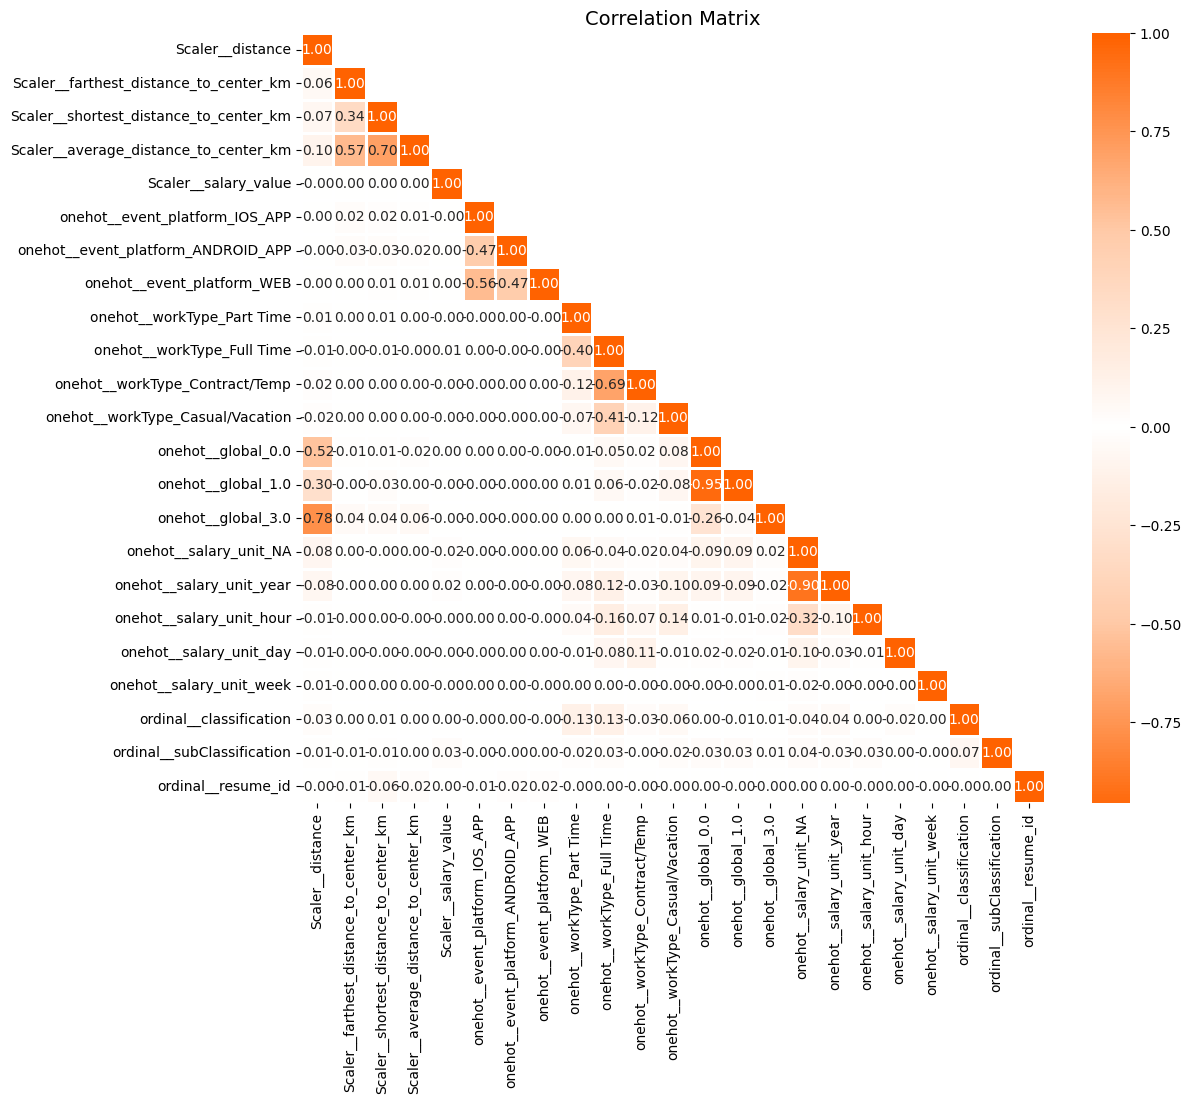

In [85]:
# visualize corr
corr_data = pd.DataFrame(X_train_transformed_apply,columns=preprocessor_apply_pure.get_feature_names_out()).corr()
from matplotlib.colors import LinearSegmentedColormap
# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_data, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### 3.2.2 Proposed Models

In [14]:
def weighted_bce(y_true, y_pred):
    pos_weight = 0.5  # Higher weight for the positive class
    loss = - (pos_weight * y_true * tf.math.log(y_pred + 1e-7) - (1 - y_true) * tf.math.log(1 - y_pred + 1e-7))
    return tf.reduce_mean(loss)

In [15]:
pca = PCA(n_components=15)  # Reduce to 15 components
X_train_apply_pca = pca.fit_transform(X_train_transformed_apply)
X_val_apply_pca = pca.transform(X_val_transformed_apply)

#### 3.2.2.1 Neural Network

In [89]:
# Define the model
nn_apply_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_apply_pca.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
nn_apply_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','precision','recall'])

# Train the model
history_apply_nn = nn_apply_model.fit(pd.DataFrame(X_train_apply_pca), pd.DataFrame(y_train_apply), epochs=10, batch_size=64, validation_data=(pd.DataFrame(X_val_apply_pca), pd.DataFrame(y_val_apply)))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
5784/5784 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8060 - loss: 20.7556 - precision: 0.1203 - recall: 0.0989 - val_accuracy: 0.8794 - val_loss: 0.4130 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
5784/5784 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8630 - loss: 0.4582 - precision: 0.1218 - recall: 0.0236 - val_accuracy: 0.8794 - val_loss: 0.4010 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
5784/5784 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8726 - loss: 0.4162 - precision: 0.1176 - recall: 0.0112 - val_accuracy: 0.8794 - val_loss: 0.3718 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
5784/5784 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8794 - loss: 0.3804 - precision: 0.0730 - recall: 5.0408e-04 - val_accuracy: 0.8794 - val_loss: 0.3681 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
5784/5784 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8796 - loss: 0.3683 - precision: 0.2012 - 

2929/2929 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
roc_auc_score: 0.5015471059451462


0.5015471059451462

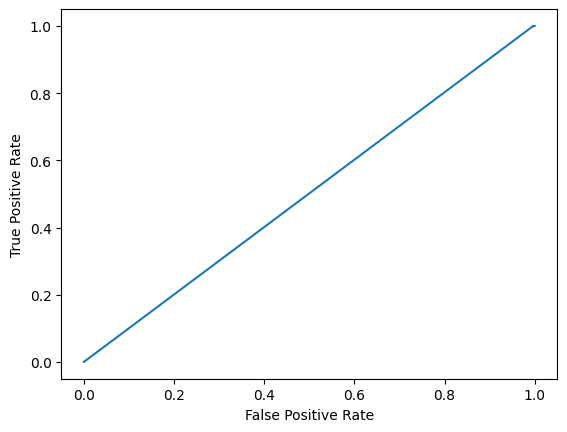

In [96]:
prediction_prob_apply_nn = nn_apply_model.predict(X_val_apply_pca)
plot_roc_curve(prediction_prob_apply_nn,y_val_apply)

In [97]:
prediction_apply_nn = tf.cast(prediction_prob_apply_nn >= 0.5, tf.int32)
accuracy,precision,recall,f1 = print_performance_metrics(prediction_apply_nn,y_val_apply)

accuracy_score: 0.8793730728605418
precision_score: 0.0
recall_score: 0.0
f1_score: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### 3.2.2.2 Random Forest

In [26]:
rf_apply_model = RandomForestClassifier()
history_apply_rf = rf_apply_model.fit(X_train_apply_pca, y_train_apply)

roc_auc_score: 0.906903915322692


np.float64(0.906903915322692)

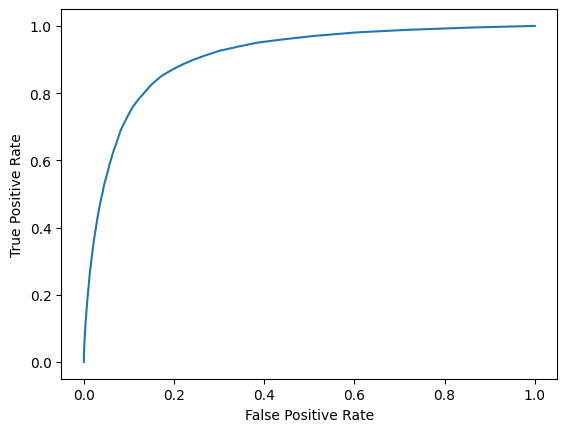

In [27]:
prediction_prob_apply_rf = rf_apply_model.predict_proba(X_val_apply_pca)
plot_roc_curve(prediction_prob_apply_rf,y_val_apply,1)

In [37]:
prediction_apply_rf = threshold_check(0.3,prediction_prob_apply_rf)
accuracy,precision,recall,f1 = print_performance_metrics(prediction_apply_rf,y_val_apply)

accuracy_score: 0.8964652661452943
precision_score: 0.5629123468426013
recall_score: 0.6339111975941978
f1_score: 0.5963058490723022


In [ ]:
# sort predictions by probability of apply a job
val_data["prediction"] = prediction_prob_apply_rf[:,1]
sorted_prediction = val_data.sort_values(["prediction"],ascending=False)

#### 3.2.2.3 Gradiend Boosting

roc_auc_score: 0.2413121606095345


0.2413121606095345

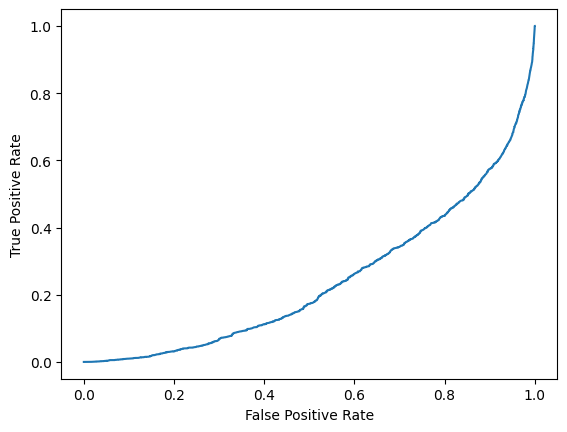

In [99]:
gb_apply_model = GradientBoostingClassifier()
# Fit the model, test sets are used for early stopping.
gb_apply_model.fit(X_train_apply_pca, y_train_apply)

roc_auc_score: 0.7586878393904655


0.7586878393904655

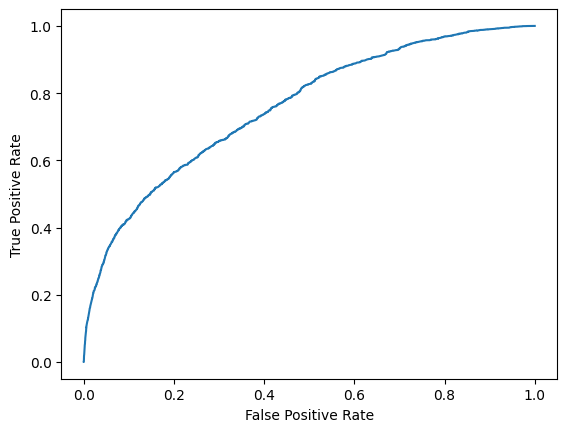

In [103]:
prediction_prob_apply_gb = gb_apply_model.predict_proba(X_val_apply_pca)
plot_roc_curve(prediction_prob_apply_gb,y_val_apply,1)

In [106]:
prediction_apply_gb = threshold_check(0.25,prediction_prob_apply_gb)
accuracy,precision,recall,f1 = print_performance_metrics(prediction_apply_gb,y_val_apply)

accuracy_score: 0.8855185805584304
precision_score: 0.5686367969494757
recall_score: 0.21103838669732886
f1_score: 0.3078312475809573


#### 3.2.2.4 Neural Network Combine

In [129]:
X_train_transformed_apply = preprocessor_apply.fit_transform(train_data)
X_val_transformed_apply = preprocessor_apply.fit_transform(val_data)
pca = PCA(n_components=70)  # Reduce to 15 components
X_train_apply_pca = pca.fit_transform(X_train_transformed_apply)
X_val_apply_pca = pca.transform(X_val_transformed_apply)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shapes
max_sequence_length = 48  # Maximum length of tokenized text sequences
vocab_size = 1000  # Vocabulary size for text tokens
num_categorical_features = 18  # Number of one-hot encoded categorical columns
num_numerical_features = 4  # Number of numerical columns

# Input layers
text_input = Input(shape=(max_sequence_length,), name='text_input')
categorical_input = Input(shape=(num_categorical_features,), name='categorical_input')
numerical_input = Input(shape=(num_numerical_features,), name='numerical_input')

# Text input branch
embedding_layer = Dense(128, activation='relu')(text_input)

# Categorical input branch
categorical_dense = Dense(32, activation='relu')(categorical_input)

# Numerical input branch
numerical_dense = Dense(32, activation='relu')(numerical_input)

# Concatenate all branches
concat = Concatenate()([embedding_layer, categorical_dense, numerical_dense])

# Combined dense network
x = Dense(128, activation='relu')(concat)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Define the model
nn_combine_apply_model = Model(inputs=[text_input, categorical_input, numerical_input], outputs=output)

# Compile the model
nn_combine_apply_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['f1_score','precision','recall','accuracy'])

# Print model summary
nn_combine_apply_model.summary()




Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 48)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ categorical_input         │ (None, 18)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ numerical_input           │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 128)            │          6,272 │ text_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_46 (Dense)          │ (None, 32)             │            608 │ categorical_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_47 (Dense)          │ (None, 32)             │            160 │ numerical_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 192)            │              0 │ dense_45[0][0],        │
│ (Concatenate)             │                        │                │ dense_46[0][0],        │
│                           │                        │                │ dense_47[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_48 (Dense)          │ (None, 128)            │         24,704 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128)            │              0 │ dense_48[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_49 (Dense)          │ (None, 32)             │          4,128 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 1)              │             33 │ dense_49[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 35,905 (140.25 KB)

 Trainable params: 35,905 (140.25 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
# history_apply_nn_combine = history
# nn_combine_apply_model = model

In [131]:
history_apply_nn_combine = nn_combine_apply_model.fit(
    [X_train_apply_pca[:,22:], X_train_apply_pca[:,4:22], X_train_apply_pca[:,0:4]],  # Input data
    pd.DataFrame(y_train_apply),  # Labels
    epochs=30,
    batch_size=32,
    validation_data=([X_val_apply_pca[:,22:], X_val_apply_pca[:,4:22], X_val_apply_pca[:,0:4]], pd.DataFrame(y_val_apply)),
)

Epoch 1/30
11567/11567 ━━━━━━━━━━━━━━━━━━━━ 68s 6ms/step - accuracy: 0.8799 - f1_score: 0.2142 - loss: 0.3717 - precision: 0.0278 - recall: 3.8679e-05 - val_accuracy: 0.8794 - val_f1_score: 0.2153 - val_loss: 0.3681 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
11567/11567 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - accuracy: 0.8798 - f1_score: 0.2144 - loss: 0.3700 - precision: 0.0598 - recall: 6.4012e-05 - val_accuracy: 0.8794 - val_f1_score: 0.2153 - val_loss: 0.3677 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
11567/11567 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - accuracy: 0.8810 - f1_score: 0.2125 - loss: 0.3663 - precision: 0.1225 - recall: 2.9753e-04 - val_accuracy: 0.8794 - val_f1_score: 0.2153 - val_loss: 0.3672 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
11567/11567 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.8811 - f1_score: 0.2123 - loss: 0.3652 - precision: 0.0700 - recall: 9.3733e-05 - val_accuracy: 0.8794 - val_f1_score: 0.2

In [132]:
model.save('/content/drive/MyDrive/seek_data/model/nn_combine_apply_model.keras')

2929/2929 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step
roc_auc_score: 0.5086241844204961


0.5086241844204961

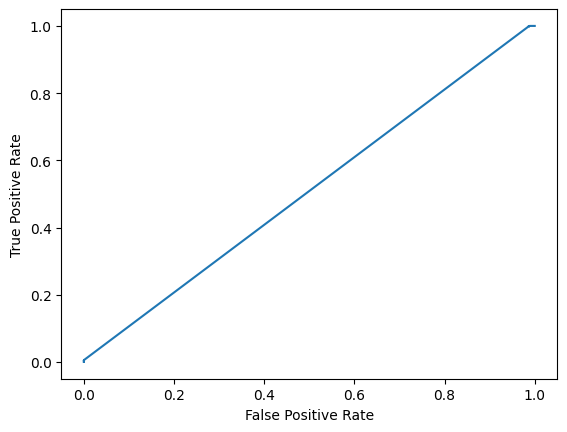

In [117]:
prediction_prob_apply_nn_combine = nn_combine_apply_model.predict([X_val_transformed_apply[:,22:], X_val_transformed_apply[:,4:22], X_val_transformed_apply[:,0:4]])
plot_roc_curve(prediction_prob_apply_nn_combine,y_val_apply)

In [118]:
prediction_apply_combine_nn = tf.cast(prediction_prob_apply_nn_combine >= 0.5, tf.int32)
accuracy,precision,recall,f1 = print_performance_metrics(prediction_apply_combine_nn,y_val_apply)

accuracy_score: 0.8795864585444962
precision_score: 0.8846153846153846
recall_score: 0.002034318061206439
f1_score: 0.004059301094246382


In [ ]:
X_train_transformed[:,0:4]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 14304 stored elements and shape (3576, 4)>

In [ ]:
job_keyword_vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3576, 1000))

In [ ]:
# print("X_text dtype:", X_text.dtype)
# print("X_categorical dtype:", X_categorical.dtype)
print("X_numerical dtype:", train_data[['farthest_distance_to_center_km','shortest_distance_to_center_km','average_distance_to_center_km','salary_value']].values.dtype)

X_numerical dtype: float64


In [ ]:
[train_data[["title_keywords","abstract_content_keywords"]], train_data[['event_platform', 'work_type', 'region_code', 'salary_unit',"classification" ,"sub_classification",'resume_id']], train_data[['farthest_distance_to_center_km','shortest_distance_to_center_km','average_distance_to_center_km','salary_value']]]

In [ ]:
train_data[["title_keywords","abstract_content_keywords"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3576 entries, 0 to 3575
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   title_keywords             3576 non-null   object
 1   abstract_content_keywords  3576 non-null   object
dtypes: object(2)
memory usage: 56.0+ KB


In [ ]:
for user_id in job_event_join_df['resume_id'].unique():
    applied_jobs = val_data[(val_data['resume_id'] == user_id) & (val_data['kind'] == 'A')]["job_id"].unique()

## 3.3 Step 3: Store Models

In [ ]:
# store model
def store_model(model,path):
  joblib.dump(model, path)
# load model
def load_model(path):
  return joblib.load(path)

# store_model(gb_apply_model,'/content/drive/MyDrive/seek_data/model/gb_apply_model.joblib')
store_model(rf_apply_model,'/content/drive/MyDrive/seek_data/model/rf_apply_model.joblib')
store_model(rf_view_model,'/content/drive/MyDrive/seek_data/model/rf_view_model.joblib')
nn_view_model.save('/content/drive/MyDrive/seek_data/model/nn_view_model.keras')
nn_apply_model.save('/content/drive/MyDrive/seek_data/model/nn_apply_model.keras')
# nn_combine_apply_model.save('/content/drive/MyDrive/seek_data/model/nn_combine_apply_model.keras')